In [1]:
import random, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
# from caas_jupyter_tools import #display_dataframe_to_user

# If sympy is needed for Hill:
try:
    from sympy import Matrix
except Exception:
    Matrix = None

# ----------------------------
# Shared metric functions
# ----------------------------
_eps = 1e-12
def _entropy_from_counts(counts, base=2):
    total = sum(counts.values())
    if total == 0: return 0.0
    H = 0.0
    for v in counts.values():
        p = v/total
        if p>0:
            H -= p * math.log(p, base)
    return H

def jensen_shannon_divergence(p_counts, q_counts, base=2):
    all_keys = set(p_counts.keys()) | set(q_counts.keys())
    Np, Nq = sum(p_counts.values()) or 1, sum(q_counts.values()) or 1
    m = {}
    for k in all_keys:
        m[k] = (p_counts.get(k,0)/Np + q_counts.get(k,0)/Nq) / 2.0
    kl_pm = 0.0; kl_qm = 0.0
    for k in all_keys:
        p = p_counts.get(k,0)/Np; q = q_counts.get(k,0)/Nq; mm = m[k]
        if p>0: kl_pm += p * math.log((p+_eps)/(mm+_eps), base)
        if q>0: kl_qm += q * math.log((q+_eps)/(mm+_eps), base)
    return 0.5*(kl_pm+kl_qm)

def mutual_information_pairs(pairs, base=2):
    N = len(pairs)
    if N==0: return 0.0
    joint = Counter(pairs)
    X = Counter(x for x,_ in pairs); Y = Counter(y for _,y in pairs)
    mi = 0.0
    for (x,y),n in joint.items():
        p_xy = n/N; p_x = X[x]/N; p_y = Y[y]/N
        mi += p_xy * math.log((p_xy+_eps)/(p_x*p_y+_eps), base)
    return mi

def confusion_jsd_avg(cipher_fun, plaintext, keyspace, sample_pairs=200, base=2):
    if len(keyspace) < 2: return 0.0
    total = 0.0; count = 0
    # If keyspace small, enumerate pairs; else sample
    for _ in range(sample_pairs):
        k1, k2 = random.sample(keyspace, 2)
        c1 = cipher_fun(plaintext, k1)
        c2 = cipher_fun(plaintext, k2)
        total += jensen_shannon_divergence(Counter(c1), Counter(c2), base=base)
        count += 1
    return total/count if count else 0.0

def diffusion_via_bigram_leakage(cipher_fun, plaintext, key, base=2):
    pt = "".join(ch for ch in plaintext.upper() if ch.isalnum())
    grams = [pt[i:i+2] for i in range(len(pt)-1)]
    if not grams:
        return 0.0
    C = cipher_fun(pt, key)
    L = min(len(grams), len(C))
    pairs = [(grams[i], C[i]) for i in range(L)]
    mi = mutual_information_pairs(pairs, base=base)
    H = _entropy_from_counts(Counter(grams), base=base)
    return 1.0 - (mi / H if H > 0 else 0.0)

def cdci_linear(alpha, C, D): return alpha*C + (1.0-alpha)*D

def compute_cdci_for_cipher(cipher_func, plaintexts, fixed_key, keyspace, alpha=0.5, sample_pairs=200):
    Cs = []; Ds = []
    for pt in plaintexts:
        C_val = confusion_jsd_avg(cipher_func, pt, keyspace, sample_pairs=sample_pairs)
        D_val = diffusion_via_bigram_leakage(cipher_func, pt, fixed_key)
        Cs.append(C_val); Ds.append(D_val)
    C_mean = float(np.mean(Cs)); D_mean = float(np.mean(Ds))
    return {'C':C_mean, 'D':D_mean, 'CDCI': cdci_linear(alpha, C_mean, D_mean), 'C_per_plain': Cs, 'D_per_plain': Ds}

# Generic helper metrics reused in each block
def fraction_changed(a, b):
    L = min(len(a), len(b))
    return sum(x!=y for x,y in zip(a[:L], b[:L])) / L if L else 0.0

def symbol_diffusion_index(cipher_func, plaintext, key, alphabet, trials=20):
    base_ct = cipher_func(plaintext, key)
    results = []
    pt_filtered = "".join(ch for ch in plaintext.upper() if ch.isalnum())
    if len(pt_filtered) == 0:
        return 0.0, 0.0
    for _ in range(trials):
        i = random.randrange(len(pt_filtered))
        new_char = random.choice([c for c in alphabet if c != pt_filtered[i]])
        P2 = pt_filtered[:i] + new_char + pt_filtered[i+1:]
        C2 = cipher_func(P2, key)
        results.append(fraction_changed(base_ct, C2))
    return float(np.mean(results)), float(np.std(results)) if len(results)>1 else 0.0

def compute_ksi(cipher_func, plaintext, key, key_variant):
    C1 = cipher_func(plaintext, key)
    C2 = cipher_func(plaintext, key_variant)
    return fraction_changed(C1, C2)

def compute_mi_from_plain_cipher_lists(plain_list, cipher_list):
    conc_plain = "".join( "".join(ch for ch in p.upper() if ch.isalnum()) for p in plain_list )
    conc_cipher = "".join(cipher_list)
    L = min(len(conc_plain), len(conc_cipher))
    pairs = list(zip(conc_plain[:L], conc_cipher[:L]))
    return mutual_information_pairs(pairs)

def compute_chi_entropy(ciphertexts, alphabet):
    text = "".join(ciphertexts)
    N = len(text)
    if N == 0: return 0.0, 0.0
    counts = Counter(text)
    expected = N / len(alphabet)
    chi2 = sum((counts[a] - expected)**2 / expected for a in alphabet)
    entropy = -sum((counts[a]/N) * math.log2(counts[a]/N) for a in counts if counts[a]>0)
    return chi2, entropy

def bootstrap_mi(pairs, n_boot=300, alpha=0.05):
    N = len(pairs)
    if N == 0: return 0.0, (0.0, 0.0)
    estimates = []
    for _ in range(n_boot):
        sample = [pairs[random.randrange(N)] for _ in range(N)]
        estimates.append(mutual_information_pairs(sample))
    estimates.sort()
    low = estimates[int((alpha/2)*n_boot)]
    high = estimates[int((1-alpha/2)*n_boot)]
    return np.mean(estimates), (low, high)

In [4]:
# ----------------------------
# 2) Substitution cipher
# ----------------------------
ALPH = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
def substitution_encrypt(text, key):
    mapping = {ALPH[i]: key[i] for i in range(26)}
    txt = "".join(ch for ch in text.upper() if 'A' <= ch <= 'Z')
    return "".join(mapping[c] for c in txt)

def random_sub_key():
    letters = list(ALPH); random.shuffle(letters); return "".join(letters)

def perturb_sub_key(key):
    k = list(key)
    i,j = random.sample(range(26),2); k[i],k[j]=k[j],k[i]
    return "".join(k)
#fixed_key = "QWERTYUIOPASDFGHJKLZXCVBNM"
def evaluate_substitution(num_texts=5, length=200, fixed_key="QAZWSXEDCRFVTGBYHNUJMIKOLP", random_key_count=10, alpha=0.5):
    plaintexts = [ "".join(random.choice(ALPH) for _ in range(length)) for _ in range(num_texts) ]
    plaintexts[0] = ("THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG" * 6)[:length]
    keyspace = [random_sub_key() for _ in range(120)]  # sample space for confusion JS divergence

    # Fixed
    fixed_metrics = {}
    sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; ent_vals=[]; mi_boot=[]
    for pt in plaintexts:
        sm,ss = symbol_diffusion_index(substitution_encrypt, pt, fixed_key, ALPH)
        sdi_vals.append(sm); ksi_vals.append(compute_ksi(substitution_encrypt, pt, fixed_key, perturb_sub_key(fixed_key)))
        C = substitution_encrypt(pt, fixed_key)
        mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[C])); chi,H = compute_chi_entropy([C], ALPH)
        chi_vals.append(chi); ent_vals.append(H)
        mb,ci = bootstrap_mi(list(zip("".join(ch for ch in pt.upper() if ch.isalnum()), C[:len(pt)])), n_boot=150)
        mi_boot.append(mb)
    cdci_out = compute_cdci_for_cipher(substitution_encrypt, plaintexts, fixed_key, keyspace, alpha=alpha)
    fixed_metrics.update({
        'SDI_mean': np.mean(sdi_vals), 'KSI_mean': np.mean(ksi_vals), 'MI_mean': np.mean(mi_vals),
        'Chi2_mean': np.mean(chi_vals), 'Entropy_mean': np.mean(ent_vals), 'MI_boot_mean': np.mean(mi_boot),
        'C': cdci_out['C'], 'D': cdci_out['D'], 'CDCI': cdci_out['CDCI']
    })
    fixed_df = pd.DataFrame([fixed_metrics])

    # Random keys
    random_keys = [random_sub_key() for _ in range(random_key_count)]
    rand_records=[]
    for rk in random_keys:
        sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; ent_vals=[]; mi_boot=[]
        for pt in plaintexts:
            sm,ss = symbol_diffusion_index(substitution_encrypt, pt, rk, ALPH)
            sdi_vals.append(sm); ksi_vals.append(compute_ksi(substitution_encrypt, pt, rk, perturb_sub_key(rk)))
            C = substitution_encrypt(pt, rk)
            mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[C])); chi,H = compute_chi_entropy([C], ALPH)
            chi_vals.append(chi); ent_vals.append(H)
            mb,_ = bootstrap_mi(list(zip("".join(ch for ch in pt.upper() if ch.isalnum()), C[:len(pt)])), n_boot=120)
            mi_boot.append(mb)
        cdci_out = compute_cdci_for_cipher(substitution_encrypt, plaintexts, rk, keyspace, alpha=alpha)
        rand_records.append({
            'key': rk, 'SDI_mean': np.mean(sdi_vals), 'KSI_mean': np.mean(ksi_vals),
            'MI_mean': np.mean(mi_vals), 'Chi2_mean': np.mean(chi_vals), 'Entropy_mean': np.mean(ent_vals),
            'MI_boot_mean': np.mean(mi_boot), 'C': cdci_out['C'], 'D': cdci_out['D'], 'CDCI': cdci_out['CDCI']
        })
    random_df = pd.DataFrame(rand_records)
    summary = pd.DataFrame({
        'mode':['fixed','random_mean'],
        'SDI_mean':[fixed_metrics['SDI_mean'], random_df['SDI_mean'].mean()],
        'KSI_mean':[fixed_metrics['KSI_mean'], random_df['KSI_mean'].mean()],
        'MI_mean':[fixed_metrics['MI_mean'], random_df['MI_mean'].mean()],
        'Entropy_mean':[fixed_metrics['Entropy_mean'], random_df['Entropy_mean'].mean()],
        'CDCI':[fixed_metrics['CDCI'], random_df['CDCI'].mean()],
        'C_index':[fixed_metrics['C'], random_df['C'].mean()],
        'D_index':[fixed_metrics['D'], random_df['D'].mean()]
    })

    ##display_dataframe_to_user("Substitution - Fixed", fixed_df)
    #display_dataframe_to_user("Substitution - Random", random_df)
    #display_dataframe_to_user("Substitution - Summary", summary)

    # plots
    x = np.arange(len(summary)); width=0.25
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(x-width, summary['CDCI'], width, label='CDCI')
    ax.bar(x, summary['C_index'], width, label='C-index')
    ax.bar(x+width, summary['D_index'], width, label='D-index')
    ax.set_xticks(x); ax.set_xticklabels(summary['mode']); ax.set_ylabel('Score'); ax.set_title('Substitution: CDCI / C / D'); ax.legend(); plt.show()

    # fixed_df.to_csv('../mnt/data/substitution_fixed.csv', index=False)
    # random_df.to_csv('../mnt/data/substitution_random.csv', index=False)
    # summary.to_csv('../mnt/data/substitution_summary.csv', index=False)
    print("Substitution saved to ./mnt/data/substitution_*.csv")
    return fixed_df, random_df, summary

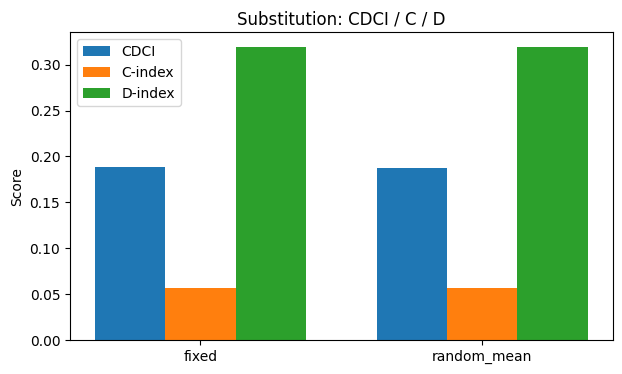

Substitution saved to ./mnt/data/substitution_*.csv


(   SDI_mean  KSI_mean   MI_mean  Chi2_mean  Entropy_mean  MI_boot_mean  \
 0     0.005     0.074  4.584468      34.26      4.584468      4.489148   
 
           C         D      CDCI  
 0  0.057039  0.319386  0.188213  ,
                           key  SDI_mean  KSI_mean   MI_mean  Chi2_mean  \
 0  JLYPUWGKAMQOESRNHZFCDBIVTX     0.005     0.080  4.584468      34.26   
 1  ZXSQHFRCBDTNJLEGKIOWAMUVPY     0.005     0.064  4.584468      34.26   
 2  RSGEIQUDXJZPKLTOMNYCHFAWBV     0.005     0.095  4.584468      34.26   
 3  LEVMXUGCWBHDFJQSNATPZOYIRK     0.005     0.083  4.584468      34.26   
 4  YACXQMBITNWSODHJFGEVRZKUPL     0.005     0.109  4.584468      34.26   
 5  FPJSMLYVWAZKBEGXOCHUIQRNDT     0.005     0.077  4.584468      34.26   
 6  NPJEGIXFDCRSBLWVYKHUZOTAQM     0.005     0.073  4.584468      34.26   
 7  DAKCWXBUGHNRTQEYPVSOMLIZFJ     0.005     0.075  4.584468      34.26   
 8  CRJNUFVLSAEGHIPTKDXQOYZBWM     0.005     0.077  4.584468      34.26   
 9  GNXLPBVWZIODREFMSJCYQKT

In [5]:
evaluate_substitution()